In [24]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas
import matplotlib as mpl
import math
import collections

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rc("savefig", dpi=1200)

sns.set_context("talk")

In [25]:
def loadmat(filepath):
    """
    Imports a .mat file exported from Julia.
    scipy.io doesn't seem to natively deal with the relevant
    types yet so we have to take care of that ourselves.
    """
    d = {}
    with h5py.File(filepath, 'r') as f:
        for k, v in f.items():
            if k == "solve_logs":
                solve_logs = dict()
                for a, b in dict(v).items():
                    solve_logs[a] = "".join(map(chr, np.ndarray.tolist(np.ndarray.flatten(np.array(b)))))
                d[k] = solve_logs
            else:
                d[k] = np.array(v)
                if np.size(d[k]) == 1:
                    d[k] = d[k][0]
    return d

In [26]:
netUUID = "2017-10-09_201838"
NORM_TYPE = 1
catalog = loadmat("solve_summaries/{}.v1.mat".format(netUUID))
len(catalog["solve_logs"])

110

In [92]:
fname = os.path.join("solve_summaries", catalog["solve_logs"]['s2_5_1'].split("/")[1])
fname
sample = loadmat(fname)
sample['solve_time']
# sample['perturbation_norm']

60.715038061141968

In [4]:
sample = loadmat(list(catalog["solve_logs"].values())[0])
print(sample.keys())

dict_keys(['solve_time', 'predicted_label', 'target_label', 'perturbation', 'sample_index', 'norm_type', 'perturbation_norm', 'perturbed_image'])


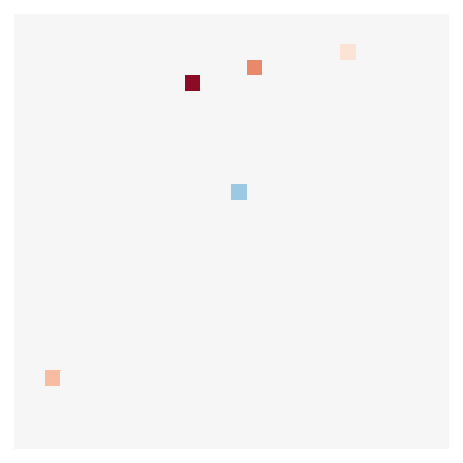

In [5]:
def get_pretty_bounds(df, field):
    base = 10**0.5

    def pow_round(x, base, sense):
        """
        Rounds x (either up, down or to the closest, based on sense) to the nearest _power_ of base.
        """
        return base**sense(math.log(x, base))
    u = pow_round(max(df[field]), base, math.ceil)
    l = pow_round(min(df[field]), base, math.floor)
    return (l, u)

def heatmap_perturbation(e, cbar=False):
    sns.set_style(style="white")
    ax = sns.heatmap(
        e,
        vmin = -1,
        vmax = 1,
        cmap=sns.color_palette("RdBu_r", 255), 
        square = True,
        cbar = cbar,
        xticklabels = False,
        yticklabels = False,
    )
    
    return ax

heatmap_perturbation(np.transpose(sample['perturbation']))

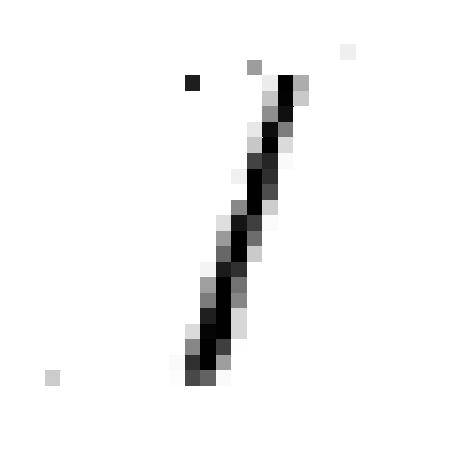

In [6]:
def heatmap_image(image, cbar=False):
    sns.set_style(style="white")
    ax = sns.heatmap(
        image, 
        vmin = 0,
        vmax = 1,
        cmap="Greys",
        square = True,
        cbar = cbar,
        xticklabels = False,
        yticklabels = False,
    )
    return ax

heatmap_image(np.transpose(sample['perturbed_image']))

In [7]:
data = []
for k, v in catalog["solve_logs"].items():
    d = loadmat(v)
    if d["target_label"] != d["predicted_label"] and d["norm_type"] == NORM_TYPE:
        data.append([
            d["solve_time"], 
            d["perturbation_norm"], 
            d["sample_index"], 
            d["target_label"], 
            d["norm_type"], 
            d["predicted_label"],
        ])

df = pandas.DataFrame(
    np.array(data), 
    columns = [
        "solve time / s", 
        "perturbation norm", 
        "sample index", 
        "target label", 
        "norm type", 
        "predicted label"
    ])

for column_name in ["target label", "predicted label"]:
    df[column_name] = df[column_name].apply(lambda x: x-1)

for column_name in ["sample index", "target label", "norm type", "predicted label"]:
    df[column_name] = df[column_name].apply(lambda x: int(x))
    
default_palettes = {
    "sample index": sns.color_palette("husl", 10),
    "target label": sns.color_palette(),
    "predicted label": sns.color_palette(),
}

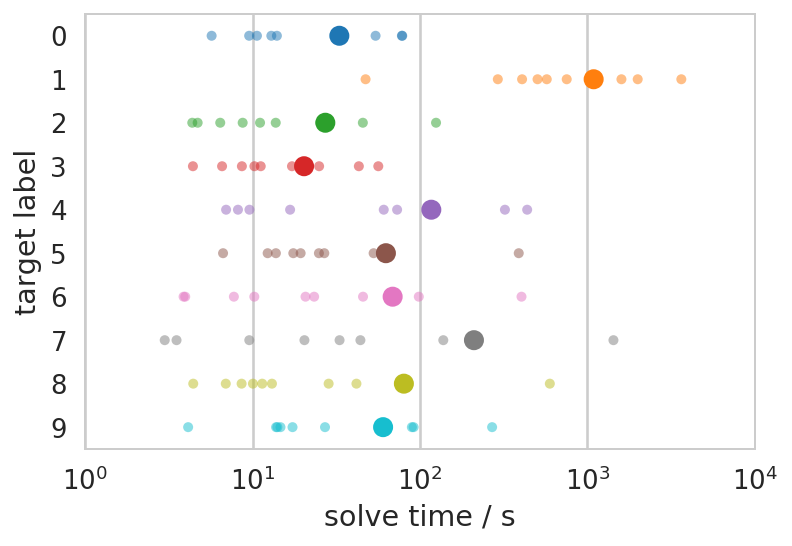

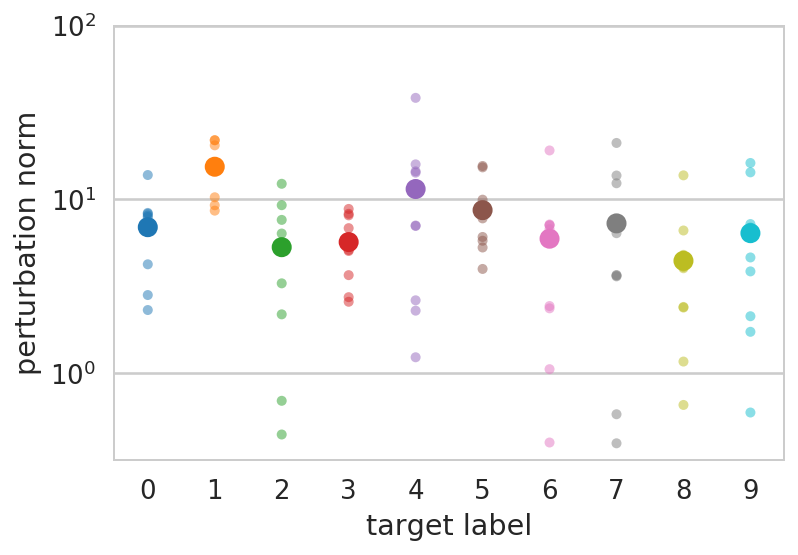

In [8]:
def strippointplot(df, values, categories, orient_vertical):
    sns.set_style(style="whitegrid")
    f, ax = plt.subplots()
    
    if orient_vertical:
        ax.set(yscale="log", ylim=get_pretty_bounds(df, values))
        x = categories
        y = values
        orient = 'v'
    else:
        ax.set(xscale="log", xlim=get_pretty_bounds(df, values))
        x = values
        y = categories
        orient = 'h'
    
    # Show each observation with a scatterplot
    sns.stripplot(
        x=x, y=y, 
        orient=orient,
        data=df, palette = default_palettes[categories],
        alpha=.5, zorder=1, ax=ax)

    # Show the conditional means
    sns.pointplot(
        x=x, y=y, 
        orient=orient,
        data=df, join=False, palette = default_palettes[categories],
        markers="o", scale=.75, ci=None, ax=ax)

strippointplot(df, "solve time / s", "target label", False)
strippointplot(df, "perturbation norm", "target label", True)


In [ ]:
def boxplot(df, values, categories, orient_vertical):
    sns.set_style(style="whitegrid")
    ax = plt.figure().add_subplot(1, 1, 1)
    if orient_vertical:
        ax.set(yscale="log", ylim=get_pretty_bounds(df, values))
        x = categories
        y = values
        orient = 'v'
    else:
        ax.set(xscale="log", xlim=get_pretty_bounds(df, values))
        x = values
        y = categories 
        orient = 'h'

    sns.boxplot(
        x = x,
        y = y,
        orient = orient,
        data = df,
        ax = ax,
        palette = default_palettes[categories],
    )
    
    return ax

boxplot(df, "solve time / s", "target label", False)
boxplot(df, "solve time / s", "sample index", False)
boxplot(df, "perturbation norm", "target label", True)

In [ ]:
def swarmplot(df, values, categories):
    sns.set_style(style="whitegrid")
    ax = plt.figure().add_subplot(1, 1, 1)
    ax.set(xscale="log", xlim=get_pretty_bounds(df, values))

    sns.swarmplot(
        x = values,
        y = "norm type",
        hue = categories,
        orient = 'h',
        data = df,
        ax = ax,
        palette = default_palettes[categories],
    )
    
    ax.get_yaxis().set_visible(False)
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=categories)
    return ax

swarmplot(df, "solve time / s", "sample index")
swarmplot(df, "solve time / s", "target label")

In [ ]:
def lmplot(df, x, y, categories, markers = 'o'):
    sns.set_style(style="whitegrid")   
    
    ax = sns.lmplot(
        x = x, 
        y = y, 
        hue = categories,
        data = df,
        ci = None,
        scatter = True, 
        fit_reg = False,
        markers = markers,
        palette = default_palettes[categories]
    )
    ax.set(xscale="log", xlim = get_pretty_bounds(df, x))
    ax.set(yscale="log", ylim = get_pretty_bounds(df, y))
    
    return ax

lmplot(df, "solve time / s", "perturbation norm", categories = "sample index", markers = 'x')
lmplot(df, "solve time / s", "perturbation norm", categories = "target label")

In [ ]:
def export_image(d, name):
    
    sns.set_style(style="white")
    e = np.transpose(d['perturbation'])
    perturbed_image = np.transpose(d['perturbed_image'])

    heatmap_perturbation(e).get_figure().savefig(
        os.path.join("images", netUUID, "perturbations", "{}.png".format(name))
    )

    heatmap_image(perturbed_image).get_figure().savefig(
        os.path.join("images", netUUID, "images", "{}.png".format(name))
    )

In [ ]:
for k, v in catalog["solve_logs"].items():
    d = loadmat(v)
    if d["norm_type"] == 1:
        export_image(d, k)